ECUACIÓN DE SCHRODINGER DEPENDIENTE DEL TIEMPO: MÉTODO DE CRANCK NICOLSON, POZO INFINITO 1D.

/var/folders/q8/64tj93sj5ns7x82k4q7vlk4h0000gn/T/ipykernel_17821/2570624713.py:82: RuntimeWarning: overflow encountered in square
  norms.append(np.sum(np.abs(psi)**2) * dx)
/var/folders/q8/64tj93sj5ns7x82k4q7vlk4h0000gn/T/ipykernel_17821/2570624713.py:81: RuntimeWarning: invalid value encountered in multiply
  psi = psi - 1j * dt / hbar * (H @ psi)


Normas finales:
  CN:            0.9999999999998024
  Euler exp.:    nan
  Euler imp.:    1.400503106962353e-27


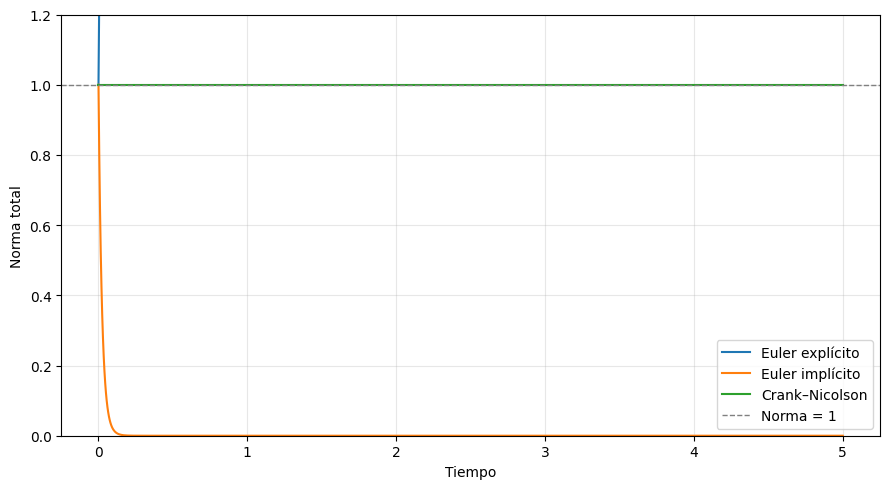

In [19]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt

# -----------------------------
# Constantes físicas
# -----------------------------
hbar = 1.0
m = 1.0

# -----------------------------
# Parámetros espaciales
# -----------------------------
x_min, x_max = -15.0, 15.0
N = 5000
x = np.linspace(x_min, x_max, N)
dx = x[1] - x[0]

# -----------------------------
# Parámetros temporales
# -----------------------------
dt = 0.005
t_max = 5.0
Nt = int(t_max / dt)
times = np.arange(Nt+1) * dt

# -----------------------------
# Potencial: pozo infinito simulado
# -----------------------------
V = np.zeros(N)
V[0] = V[-1] = 1e6

# -----------------------------
# Estado inicial
# -----------------------------
x0 = -1.0
sigma = 1.0
k0 = 14.0
psi0 = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.exp(1j * k0 * x)
psi0 /= np.sqrt(np.sum(np.abs(psi0)**2) * dx)

# -----------------------------
# Laplaciano y Hamiltoniano
# -----------------------------
main_diag = -2.0 * np.ones(N)
off_diag = 1.0 * np.ones(N-1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]) / dx**2

H = -(hbar**2 / (2*m)) * laplacian + diags(V, 0)
I = diags([np.ones(N)], [0])

# -----------------------------
# Crank–Nicolson
# -----------------------------
A = (I + 1j * dt / (2*hbar) * H).tocsc()
B = (I - 1j * dt / (2*hbar) * H)
A_lu = splu(A)

# -----------------------------
# Euler implícito
# -----------------------------
M_imp = (I + 1j * dt / hbar * H).tocsc()
M_imp_lu = splu(M_imp)

# -----------------------------
# Evoluciones
# -----------------------------
def evolve_CN():
    psi = psi0.copy()
    norms = [np.sum(np.abs(psi)**2) * dx]
    for _ in range(Nt):
        psi = A_lu.solve(B.dot(psi))
        norms.append(np.sum(np.abs(psi)**2) * dx)
    return np.array(norms)

def evolve_euler_explicit():
    psi = psi0.copy()
    norms = [np.sum(np.abs(psi)**2) * dx]
    for _ in range(Nt):
        psi = psi - 1j * dt / hbar * (H @ psi)
        norms.append(np.sum(np.abs(psi)**2) * dx)
    return np.array(norms)

def evolve_euler_implicit():
    psi = psi0.copy()
    norms = [np.sum(np.abs(psi)**2) * dx]
    for _ in range(Nt):
        psi = M_imp_lu.solve(psi)
        norms.append(np.sum(np.abs(psi)**2) * dx)
    return np.array(norms)

# -----------------------------
# Ejecutar
# -----------------------------
norms_CN    = evolve_CN()
norms_exp   = evolve_euler_explicit()
norms_imp   = evolve_euler_implicit()

print("Normas finales:")
print("  CN:           ", norms_CN[-1])
print("  Euler exp.:   ", norms_exp[-1])
print("  Euler imp.:   ", norms_imp[-1])

# -----------------------------
# Gráfica
# -----------------------------
plt.figure(figsize=(9,5))

plt.plot(times, norms_exp, label="Euler explícito")
plt.plot(times, norms_imp, label="Euler implícito")
plt.plot(times, norms_CN,  label="Crank–Nicolson")

plt.axhline(1.0, linestyle="--", linewidth=1, color="gray", label="Norma = 1")

plt.xlabel("Tiempo")
plt.ylabel("Norma total")
plt.ylim(0, max(1.2, np.max(norms_exp[:200])) )  # deja sitio a la explosión
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
